In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
#Courtesy of Martin Thoma (on Stack Overflow)
def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

In [3]:
#loop over all the wells in the database that are leak potentials and calculate a metric
#called 'risk'. The metric's purpose is to be a very rough intitial estimate of leak risk
#of each one of these wells by the proximity of other injection wells to it.
#Each injection well adds the inverse of its distance square to the risk.
#This is a very rough measure and needs to be refined much more using, formation injected into,
# depth injected, flow rate injected, depth of the leak wells etc.
LeakPotDF = pd.read_csv('LeakPot.csv')
ActInjDF = pd.read_csv('ActInj.csv')
for index1,row1 in LeakPotDF.iterrows():
    risk = 0
    Lat1 = row1['Latitude']
    Lon1 = row1['Longitude']
    for index2, row2 in ActInjDF.iterrows():
        Lat2 = row2['Latitude']
        Lon2 = row2['Longitude']
        dist = distance((Lat1, Lon1), (Lat2, Lon2))
        if dist > 0.1:
            risk += dist**-2
    LeakPotDF.loc[index1, 'Leak Risk'] = risk

In [4]:
LeakPotDF.to_csv('LeakPot.csv')

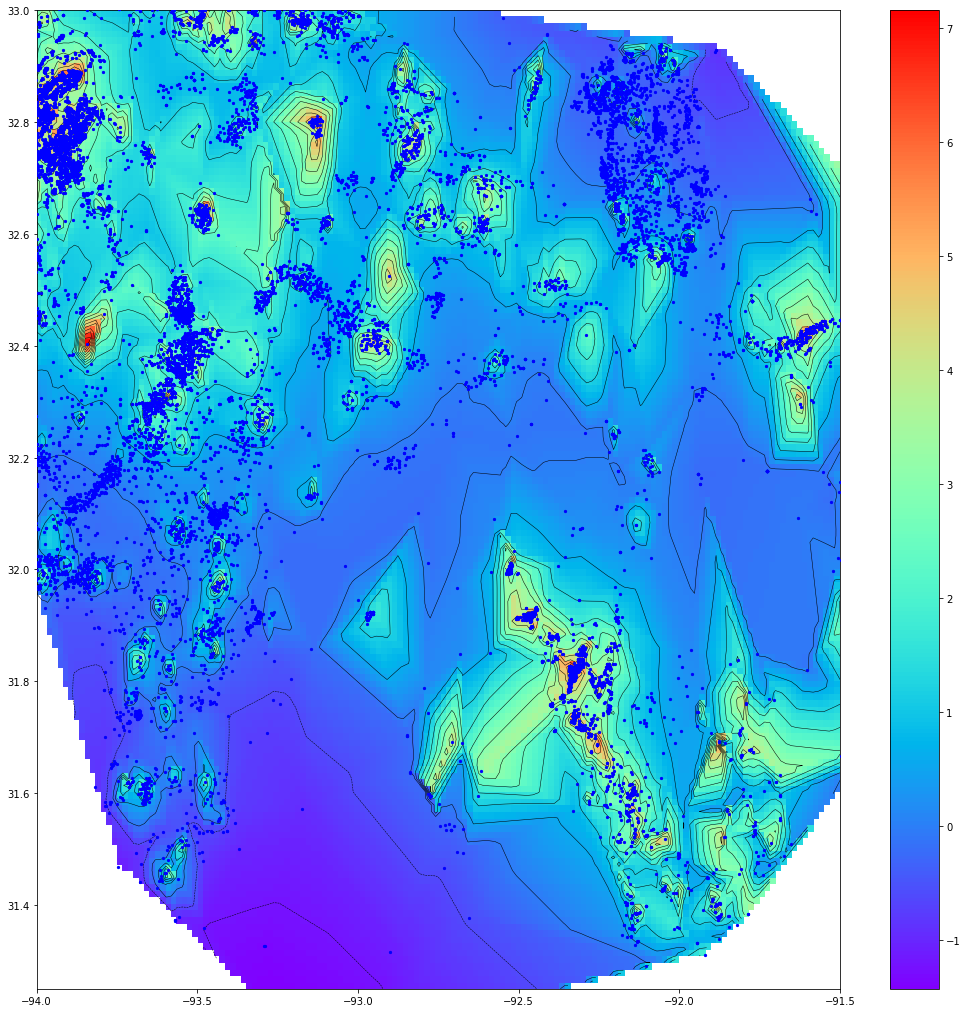

In [5]:
#Create a contour plot interpolated by the values of risk calculated for each well in the 
#part of database for wells that are not being used.

import matplotlib.mlab as ml
ndata = 100
ny, nx = 150, 150
xmin, xmax = -94, -91.5
ymin, ymax = 31.25, 33
# x = np.linspace(1, 10, ndata)
# y = np.linspace(1, 10, ndata)

x = LeakPotDF['Longitude']
y = LeakPotDF['Latitude']
z = LeakPotDF['Leak Risk']

xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
zi = ml.griddata(x, y, np.log(z), xi, yi, interp='linear')

plt.figure(figsize=(18,18))
plt.contour(xi, yi, zi, 15, linewidths = 0.5, colors = 'k')
plt.pcolormesh(xi, yi, zi, cmap = plt.get_cmap('rainbow'))

plt.colorbar() 
plt.scatter(x, y, marker = 'o', c = 'b', s = 5, zorder = 10)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

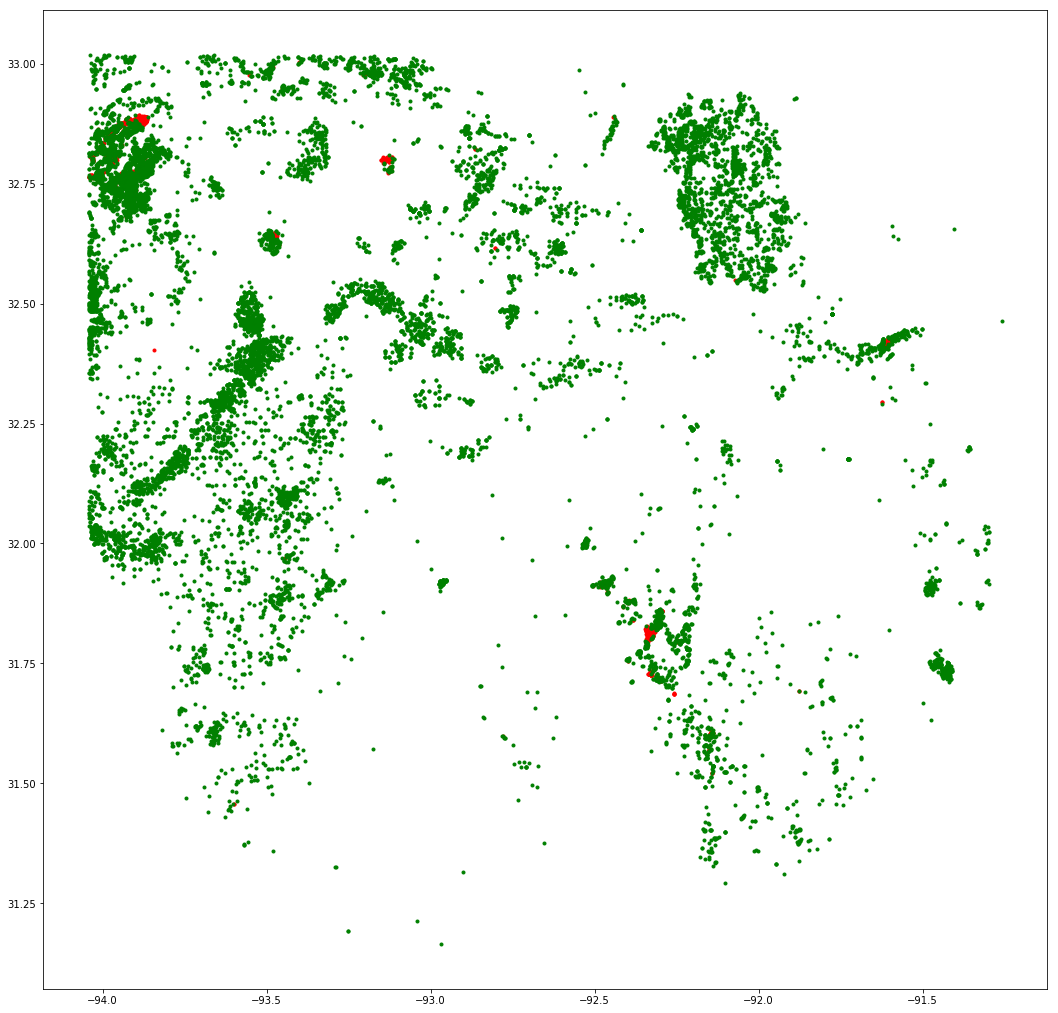

In [8]:
#Another way to look at and plot the current data. Group each well into a high risk (red, 25% high quantile)
#and low risk (green, the rest).

Quant75 = LeakPotDF['Leak Risk'].quantile(0.90)
LeakPotDFHigh = LeakPotDF[LeakPotDF['Leak Risk'] > Quant75]
LeakPotDFLow = LeakPotDF[LeakPotDF['Leak Risk'] <= Quant75]

plt.figure(figsize=(18,18))
plt.plot(LeakPotDFHigh['Longitude'],LeakPotDFHigh['Latitude'],'r.')
plt.plot(LeakPotDFLow['Longitude'],LeakPotDFLow['Latitude'],'g.')
plt.show()

In [9]:
import gmplot 

gmapx = gmplot.GoogleMapPlotter(32, -93, 10)
gmapx.scatter(LeakPotDFHigh['Latitude'], LeakPotDFHigh['Longitude'], 'red', size = 0.1)
gmapx.draw('gmplot.html')